In [1]:
import re
import io
import numpy as np
import pandas as pd
import openpyxl
import subprocess as sp
import matplotlib.pyplot as plt

In [2]:
def request(command):
    child = sp.Popen(command.split(), stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr =child.communicate()
    child.terminate()
    return stdout.decode()

In [3]:
time = 'Start=0601-00:00:00 End=0630-23:59:59'

command = f'sreport -T cpu,gres/gpu:7g.40gb,gres/gpu:1g.5gb,gres/gpu:2g.10gb,gres/gpu:3g.20gb,mem -t Hour cluster AccountUtilizationByUser \
Accounts=root {time} Format=Account,Login%20,TresName%30,Used -P'

timeCommand = f'sreport -t Second cluster AccountUtilizationByUser {time}'

In [4]:
colorDict = {'IDLE':(.7,.7,.7),
             'changlab':'#2F3A8F',
             'lolab':'#CCD1E4',
             'yanglab':'#FE7E6D'}

In [5]:
totalTimePt = re.compile('(\d+) secs')
totalTime = int(totalTimePt.findall(request(timeCommand))[0])

In [6]:
print(totalTime/60/60)

568.0


In [7]:
print(request(timeCommand).split('\n')[1][33:])

2022-06-01T00:00:00 - 2022-06-24T15:59:59 (2044800 secs)


In [8]:
cpuTotalHour = totalTime/60/60*248
memTotalHour = totalTime/60/60*900*1000
gpu1gTotalHour = totalTime/60/60*7
gpu2gTotalHour = totalTime/60/60*6
gpu3gTotalHour = totalTime/60/60*3
gpu7gTotalHour = totalTime/60/60*4
gpuTotalHour = totalTime/60/60*8
totalHour = [cpuTotalHour, memTotalHour, gpu1gTotalHour, gpu2gTotalHour, gpu3gTotalHour, gpu7gTotalHour, gpuTotalHour]

In [9]:
devices = ['CPU',
           'Memory',
           '1/7 A100',
           '2/7 A100',
           '3/7 A100',
           '7/7 A100',
           'GPU']

gpuDevces = ['1/7 A100',
             '2/7 A100',
             '3/7 A100',
             '7/7 A100']
mainDevices = ['CPU', 'Memory', 'GPU']

deviceDict = {}

for i, j in zip(devices, totalHour):
    deviceDict[i] = j

In [10]:
df = pd.read_csv(io.StringIO(request(command)),sep='|',skiprows=4)
df = df.dropna(subset=['Login'])

In [11]:
labs =  df.groupby(['Account']).sum().index.to_list()

if 'root' in labs:
    labs.remove('root')

df = df[df['Account'].isin(labs)]
df = df[~df['Login'].isin(['prx_kuenway'])]

In [12]:
df['TRES Name'].replace(['cpu'], 'CPU', inplace=True)
df['TRES Name'].replace(['mem'], 'Memory', inplace=True)
df['TRES Name'].replace(['gres/gpu:1g.5gb'], '1/7 A100', inplace=True)
df['TRES Name'].replace(['gres/gpu:2g.10gb'], '2/7 A100', inplace=True)
df['TRES Name'].replace(['gres/gpu:3g.20gb'], '3/7 A100', inplace=True)
df['TRES Name'].replace(['gres/gpu:7g.40gb'], '7/7 A100', inplace=True)

##### Sum all gpu

In [13]:
gpuSum = df.groupby(['Account', 'TRES Name']).sum()

gpuUsage = []

for lab in labs:
    gg = np.array([gpuSum.loc[lab, '7/7 A100'] * 7/7,
                   gpuSum.loc[lab, '3/7 A100'] * 3/7,
                   gpuSum.loc[lab, '2/7 A100'] * 2/7,
                   gpuSum.loc[lab, '1/7 A100'] * 1/7,])
    
    gpuUsage.append({'Account':lab,
                     'Login':'-',
                     'TRES Name':'GPU',
                     'Used':gg.sum()})

df = df.append(gpuUsage)

##### get IDLE

In [14]:
idle = []

for key in deviceDict.keys():
    idleTime = deviceDict[key] - df.groupby(['TRES Name']).sum().loc[key, 'Used']
    idle.append({'Account':'IDLE',
                 'Login':'-',
                 'TRES Name':key,
                 'Used':idleTime})

df = df.append(idle)

##### Calculate usage %

In [15]:
df['Usage %'] = 0

for i in deviceDict.keys():
    typeSel = df['TRES Name']==i
    df.loc[typeSel, 'Usage %'] = df[typeSel]['Used']*100 / (deviceDict[i])

In [16]:
groupTresAcc = df.groupby(['TRES Name','Account']).sum()

##### Report figure

In [17]:
cutoff = 2

def my_autopct(pct):
    return ('%.2f%%' % pct) if pct > cutoff else ''

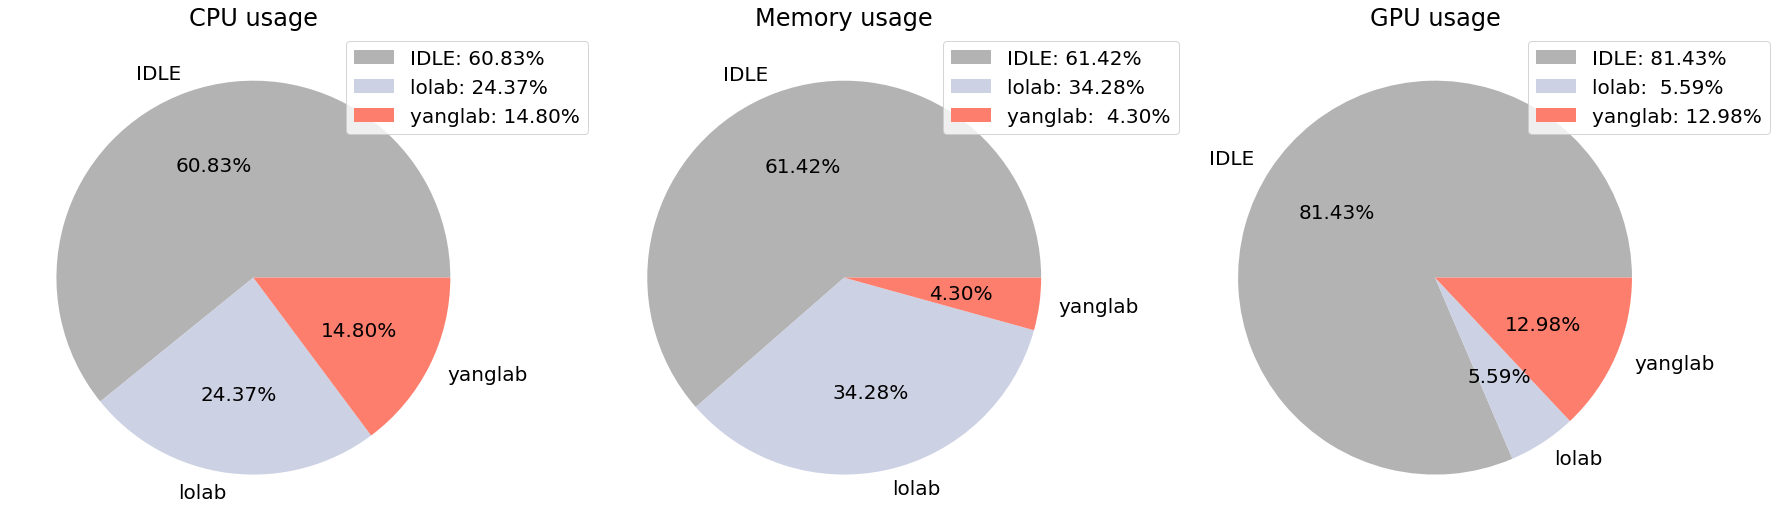

In [18]:
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))

for idx, key in enumerate(mainDevices):

    currUsage = groupTresAcc.loc[key,'Usage %']
    label = [k if currUsage[k] > cutoff else None for k in currUsage.keys()]
    color = [colorDict[i]for i in currUsage.keys()]
    plt.sca(axs[idx])
    plt.pie(x = groupTresAcc.loc[key, 'Usage %'],
            labels = label,
            autopct = my_autopct,
            textprops={'fontsize': 20},
            colors=color)
    plt.title(f'{key} usage', fontsize=24)
    legends = [f'{k}: {v:>5.2f}%' for k,v in zip(currUsage.keys(), currUsage.values)]
    plt.legend(legends, loc=1, bbox_to_anchor=(1.2,1), prop={'size': 20})
# plt.savefig('figure1.png', dpi=300)

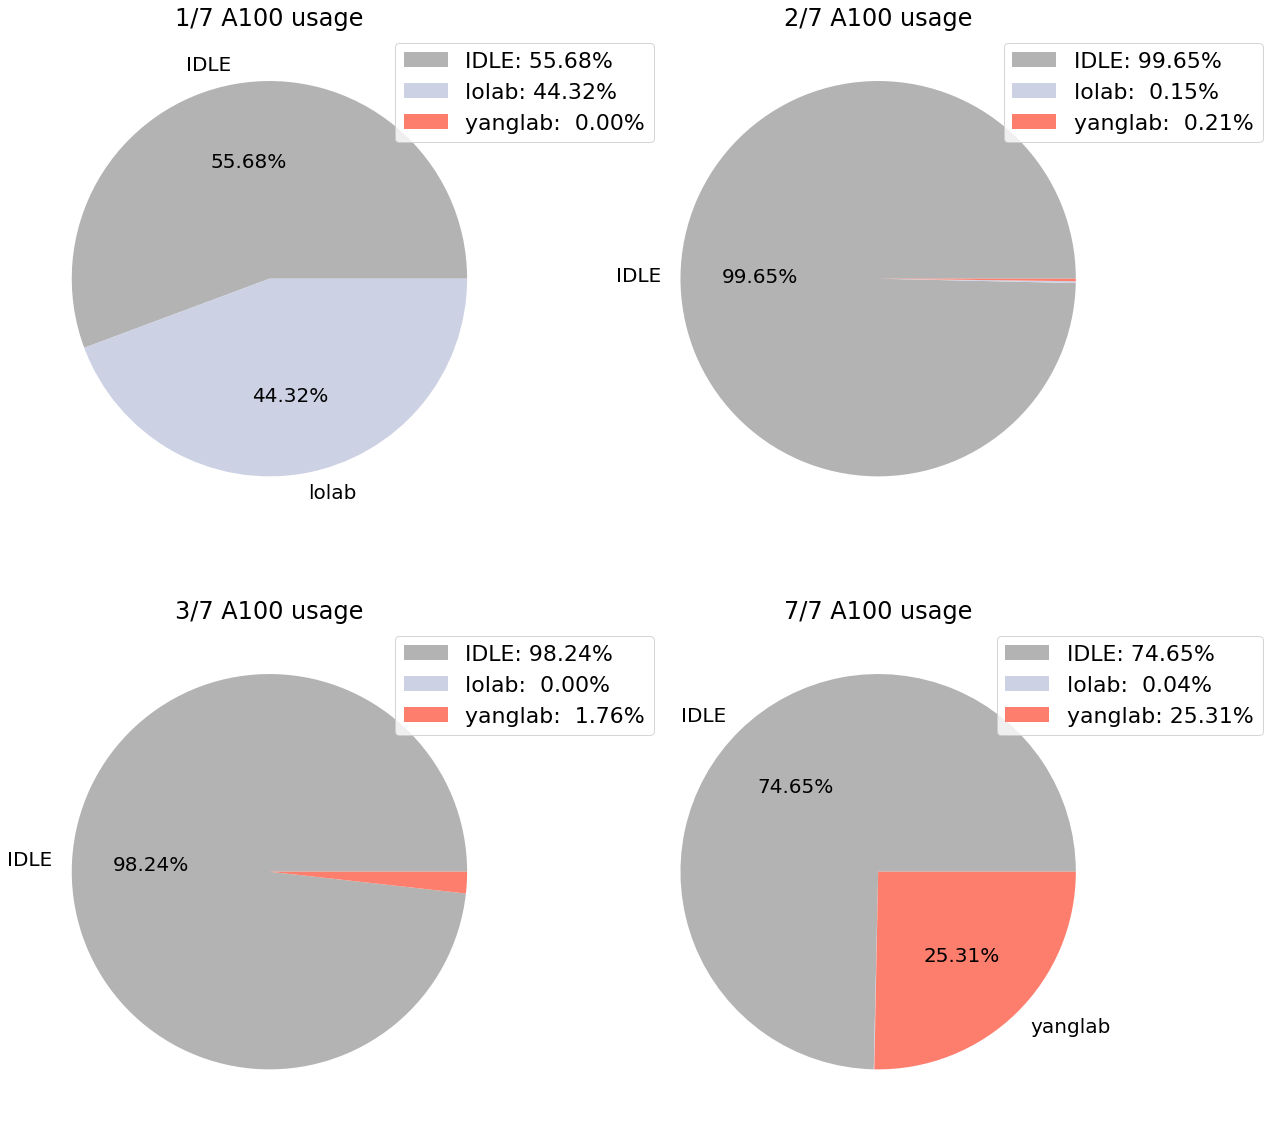

In [19]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))

row = 0
col = 0

for key in gpuDevces:
    
    currUsage = groupTresAcc.loc[key,'Usage %']
    label = [k if currUsage[k] > cutoff else None for k in currUsage.keys()]
    color = [colorDict[i]for i in currUsage.keys()]
    plt.sca(axs[row, col])

    plt.pie(x = groupTresAcc.loc[key, 'Usage %'],
            labels = label,
            autopct = my_autopct,
            textprops={'fontsize': 20},
            colors=color)

    plt.title(f'{key} usage', fontsize=24)
    
    legends = [f'{k}: {v:>5.2f}%' for k,v in zip(currUsage.keys(), currUsage.values)]
    plt.legend(legends, loc=1, bbox_to_anchor=(1.3,1), prop={'size': 22})
    
    if col == 1:
        col = 0
        row += 1
    else:
        col += 1
# plt.savefig('figure2.png', dpi=300)

In [20]:
df.rename(columns = {'Account':'Lab', 'Login':'Username', 'TRES Name':'Resource'}, inplace = True)

In [21]:
df

,Lab,Username,Resource,Used,Usage %
24,lolab,lo_chi_tin_shih,CPU,0.0,0.000000
25,lolab,lo_chi_tin_shih,Memory,9.0,0.000002
26,lolab,lo_chi_tin_shih,1/7 A100,0.0,0.000000
27,lolab,lo_chi_tin_shih,2/7 A100,0.0,0.000000
28,lolab,lo_chi_tin_shih,3/7 A100,0.0,0.000000
...,...,...,...,...,...
2,IDLE,-,1/7 A100,2214.0,55.684105
3,IDLE,-,2/7 A100,3396.0,99.647887
4,IDLE,-,3/7 A100,1674.0,98.239437
5,IDLE,-,7/7 A100,1696.0,74.647887


In [24]:
fileName = 'report_June.xlsx'

labdf = df[:-10].groupby(['Lab', 'Username', 'Resource']).sum()
with pd.ExcelWriter(fileName, engine='openpyxl', mode='w') as writer:
    for lab in labs:
        labdf.loc[lab].to_excel(writer, sheet_name=lab)

In [23]:
df.groupby(['Lab']).sum()

,Used,Usage %
Lab,,
IDLE,3.140702e+08,531.893557
lolab,1.752667e+08,108.746685
yanglab,2.201988e+07,59.359758
